# Guía 2 - Grupo 2
## Matías Bergerman, Pablo González Leiro, Tobias Demeco, Matías Tripoli

In [19]:
#Codigo en general para todos los ej (imports y eso)

## ex1.m

From [fspecial docs](http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/images/fspecial.html):

fspecial creates unsharp filters using:

![fspecial-unsharp](notebook-images/fspecial-unsharp.gif)

When not passing the $\alpha$ parameter, its default value is $\frac{1}{5}$


fspecial("disk") returns a circular averaging filter (pillbox) within the square matrix of side 2*radius+1. The default radius is 5.


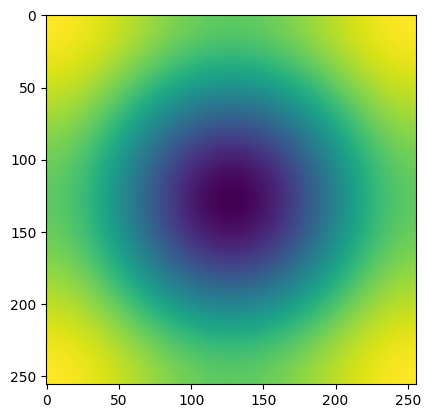

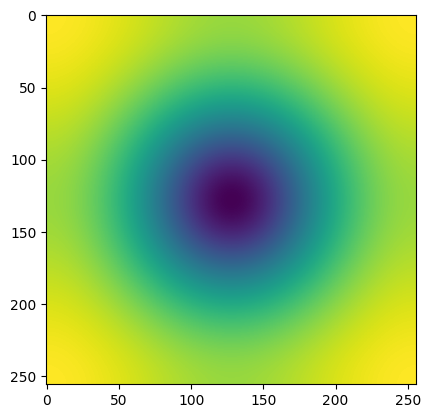

In [20]:
#Codigo para ex1.m

import numpy as np
import plotly.graph_objects as go # We use plotly to get a nice 3d image of the filter spectrum
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.signal import convolve2d

# Function that simulates Matlab's fspecial function behaviour
def fspecial(filter_type, radius=5, alpha=0.2): 
	if (filter_type == "disk"):
		r=radius
		[y,x] = np.ogrid[-r:r+1, -r:r+1]
		disk = x**2+y**2 <= r**2
		disk = disk.astype(float)
		sumdisk=disk.sum()
		if sumdisk!=0:
			disk/=sumdisk
		h = disk
	elif (filter_type == "unsharp"):
		a=alpha
		h = 1/(a+1) * np.array([[-a, a-1, -a], [a-1, a+5, a-1], [-a, a-1, -a]])
	return h

# Function that simulates Matlab's conv2 function behaviour (The rotations are to get exact conv2 behaviour)
def conv2(img, h, mode="same"):
	return np.rot90(convolve2d(np.rot90(img,2), np.rot90(h, 2), mode=mode), 2)

# The three options found in ex1.m
#h = np.array([[0, 1/6, 0], [1/6, 1/3, 1/6], [0, 1/6, 0]])
#h = fspecial("disk")
h = fspecial("unsharp")

# Code that simulates the freqz2 Matlab function by transforming the filter coeficients using N=128
# Shifting that transformation to the origin and showing it on a nice graph
N = 256
H = fft.fftshift(fft.fft2(h, [N, N]))
f = fft.fftshift(fft.fftfreq(N))
fig = go.Figure(data=[go.Surface(x=f, y=f, z=np.abs(H))])
fig.show()

# We create a 256x256 image and make it an unit impulse image by setting the central pixel to 1
big = np.zeros((N, N))
big[int(N/2 - 1), int(N/2 - 1)] = 1


# We then use our defined conv2 function to convolute the filter's coeficients with the image
h1 = conv2(big, h)

# Now we can see the resulting image spectrum using fft2
S = fft.fft2(h1)
SM = np.absolute(S)

# And we plot the image spectrum shifted to the origin
plt.imshow(fft.fftshift(SM/np.amax(SM)))
plt.show()

#Lastly, we can use logarithmic scale to get a better understanding of the spectrum
IMd = np.log(1 + np.absolute(SM))
plt.imshow(fft.fftshift(IMd/np.amax(IMd)))
plt.show()



## ex2.m

We use OpenCV to open and filter the image, as the equivalent to imread and imfilter from Matlab, and use the ex1.m kernels.

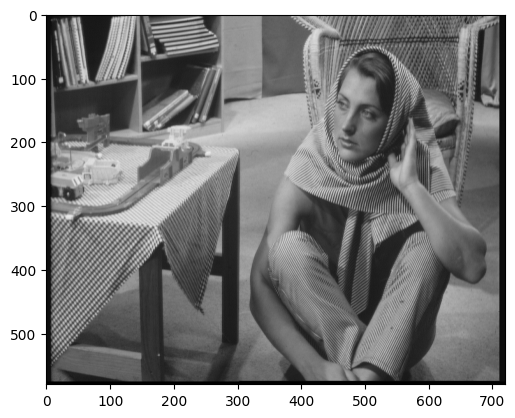

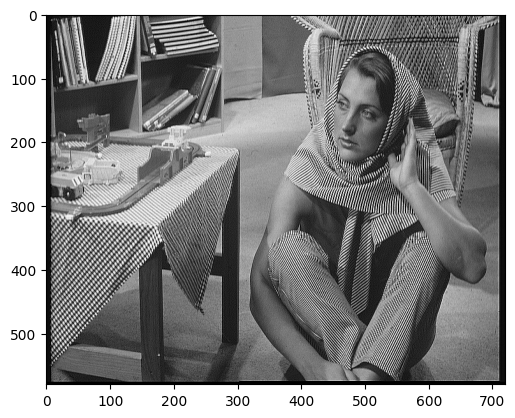

In [21]:
#Codigo para ex2.m

import cv2

## Function that simulates Matlab's imfilter function behaviour 
def imfilter(img, h):
	out = cv2.filter2D(img, -1, h)
	return out

# We have the same three filters as in ex1.m
#h = np.array([[0, 1/6, 0], [1/6, 1/3, 1/6], [0, 1/6, 0]])
#h = fspecial("disk")
h = fspecial("unsharp")

# We open the barbara image and show it
b = cv2.imread("barbara.png")
b_rgb = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
plt.imshow(b_rgb)
plt.show()

#We then filter the image using the selected filter and show it
h1 = imfilter(b,h)
h1_rgb = cv2.cvtColor(h1, cv2.COLOR_BGR2RGB)
plt.imshow(h1_rgb)
plt.show()


## spect.m
(Portar spect.m a Python y explicar como funciona)

In [22]:
#Codigo para spect.m

## myallias.m
(Portar myallias.m a Python y explicar como funciona)

In [23]:
#Codigo para myallias.m

## viasampling.m (upsampling/downsampling.m)
(Portar viasampling.m a Python y explicar como funciona, tambien hay que portar y explicar upsampling.m y downsampling.m en esta sección)

In [24]:
#Codigo para downsampling.m y upsampling.m

In [25]:
#Codigo para viasampling.m

## interpol.m y alliasorg.m?
(Estas dos no las mencionó Dani pero dijo que habia que portar todo, asi que asumo que hay que portarlas y explicarlas tambien)

In [26]:
#Codigo para interpol.m

In [27]:
#Codigo para alliasorg.m

## image_aliasing_new.m
(La mas heavy, pero si estan las otras sale)

In [28]:
#Codigo para image_aliasing_new.m